In [36]:
# --- Standard libraries
import heapq as hq
# --- PyTorch
import torch
import lightning as L
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# --- Bokeh
from bokeh.io import output_notebook, show, export_svg
from bokeh.models import Label
from bokeh.layouts import row
output_notebook()
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
# --- Modules from local files
from GNN import GNN_model
# from utils.utils import bokeh_spectra, calculate_rse, bokeh_hist, get_spec_prediction

Loading BokehJS ...

In [2]:
# --- Define parameters for GNN model
num_tasks = 200
num_layers = 3
in_channels = [15, 64, 128]
out_channels = [64, 128, 256]
gnn_type = "gcn"
heads = 1
drop_ratio = 0.5
graph_pooling = "mean"
learning_rate = 0.01

In [13]:
model = GNN_model(
    num_tasks,
    num_layers,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
    learning_rate
)
device = 'cpu'
model.to(device)

GNN_model(
  (convs): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)

In [14]:
checkpoint = './lightning_logs/version_6/checkpoints/val_loss=0.008031-epoch=38.ckpt'
hparam = './lightning_logs/version_6/hparams.yaml'

model = GNN_model.load_from_checkpoint(checkpoint, hparams_file=hparam)

In [15]:
# test_dataset = torch.load("./processed/test_version3_charge_hot_num.pt", weights_only=False)
test_dataset = torch.load("./processed/test_data_coronene.pt")
# --- Show details of the dataset
print(test_dataset)

/tmp/ipykernel_83843/3434842187.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load("./processed/test_data_coronene.pt")


In [19]:
for x in test_dataset:
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred = model(x)

    break

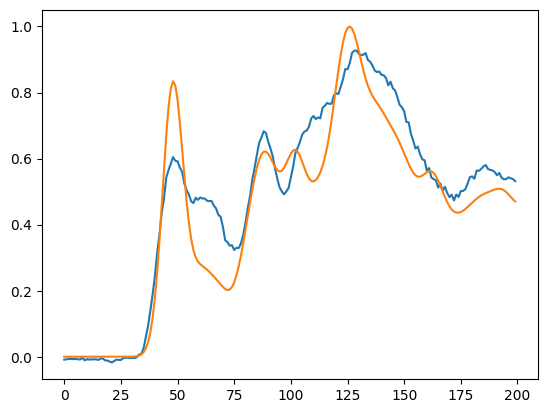

In [25]:
import matplotlib.pyplot as plt

plt.plot(pred.flatten().detach().numpy())
plt.plot(test_dataset[0].spectrum)
plt.show()

In [ ]:
def get_spec_pred(model, index, data, device):
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred = model(data)

    pred_spectrum = pred.flatten().detach().numpy()
    true_spectrum = data.spectrum.detach().numpy()

    return pred_spectrum, true_spectrum

In [29]:
cor_pred = {}
cor_tru = {}

for index, data in enumerate(test_dataset):
    cor_pred[index], cor_tru[index] = get_spec_pred(model, index, data, device)

In [30]:
model_dict = [cor_pred, cor_tru]

In [31]:
predict = model_dict[0]
true = model_dict[1]

In [37]:
wasser = []
mse = []
rse = []
spear = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(true[x], predict[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(true[x], predict[x])
    mse.append(mse_temp)
    # RSE
    # rse_temp = calculate_rse(true[x], predict[x])
    # rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(true[x], predict[x])
    spear.append(spear_temp[0])

ave_wasser = sum(wasser) / len(wasser)
ave_spear = sum(spear) / len(spear)
ave_mse = sum(mse) / len(mse)
# ave_rse = sum(rse) / len(rse)

print(f"Average Wasserstein distance = {ave_wasser}")
print(f'Average spearman correlation coefficient = {ave_spear}')
print(f"Average MSE = {ave_mse}")
# print(f'Average RSE = {ave_rse}')

Average Wasserstein distance = 0.051082628362768764
Average spearman correlation coefficient = 0.9394592941746623
Average MSE = 0.009923570789396763
